In [164]:
# necessary imports
import PIL.Image as Image
from PIL import Image, ImageSequence

# plotting import
import pylab as py
# to show plots directly in the notebook
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

import numpy as np
import cv2

In [ ]:
cap = cv2.VideoCapture('pupeTrackr.mp4')

while(cap.isOpened()):
    try:
        ret, frame = cap.read()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
       # plt.imshow(frame)
        cv2.imwrite("frame%d.jpg" % ret, frame)
        plt.imshow(frame)
       

        display.clear_output(wait=True)
        display.display(plt.gcf())

    except KeyboardInterrupt:
        cap.release()

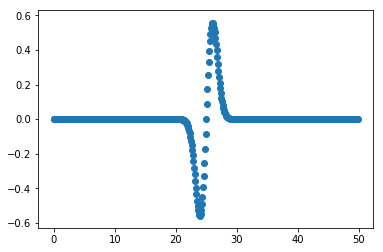

In [165]:
# first, create filters for scoring the presence of pupil in images
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

def dog(x, center = 25, sig = 1):
    # difference of gaussians separated by 1 sigma
    # which is roughly the distance between the peaks
    return ( 
        gaussian(x,center+sig/2.0, sig) -
        gaussian(x, center-sig/2.0, sig) )

x = np.arange(0,50,0.1)
y = [dog(i) for i in x]
py.scatter(x,y)

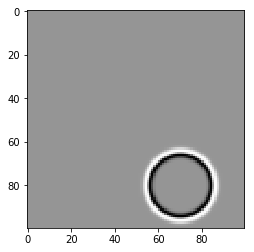

In [166]:
# let's look at a radial plot of this with the "center" at radius 25.
# could be a good filter for detecting pupils...
def ringed_dog_filter(dog_filter, center=(80,70), 
                      radius=15):
    # note, this changes the passed dog_filter
    size = dog_filter.shape
    dog_filter *= 0
    # x and y are both the indices and the values used
    for x in range(0,size[0]):
        for y in range(0,size[1]):
            r = np.sqrt( (x-center[0])**2 + (y-center[1])**2 )
            dog_filter[x,y] = dog(r, center=radius, sig=1)
    # normalize the mean and standard deviation
    #dog_filter -= np.mean(dog_filter)
    # dog_filter /= np.std(dog_filter)
    # and to assure the strength is proportional to the radius
    dog_filter /= radius  # not sure about this

img = np.zeros((100,100));
ringed_dog_filter(img)
py.imshow(img, cmap=py.cm.Greys_r)

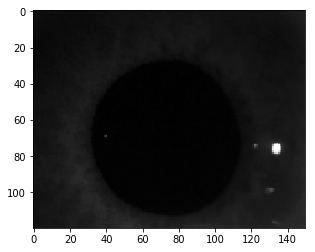

In [330]:
def get_image_mat(filename):
    img = Image.open(filename).convert('LA')
    img = np.asarray(img, 'double').transpose()  
    img = img[0,:,:] # just one layer
    return img

def show_image(img):
    py.imshow(img.transpose(), cmap=py.cm.Greys_r)

img = get_image_mat('frame1.jpg')
show_image(img)

In [331]:
# now let's apply this dog filter to score pupil sizes...

In [332]:
def filter_score(img, dog_filter, center, radius):
    # use a ringed dog filter on the image
    ringed_dog_filter(dog_filter, center, radius)
    return np.sum(np.multiply(dog_filter, img))

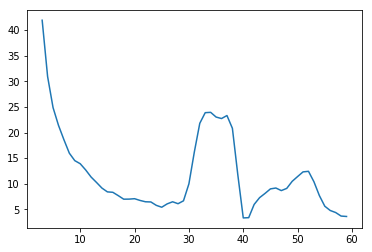

In [333]:
def filter_score_plot(img, center, radii):    
    scores = []
    dog_filter = np.zeros(img.shape)
    for r in radii:
        scores.append(filter_score(img,dog_filter, center,r))
    return scores

center = (70,80) # can be calculated automatically, but assumed given now
radii = np.arange(3,60)
scores = filter_score_plot(img,center, radii)
py.plot(radii,scores)
#py.ylim(0,np.max(scores))

In [334]:
def max_scores(x, y, min_separation=10, num_scores=2):
    # returns the maximums in the graph, with a minimum separation between them
    y_arr = np.array(y)
    indices = np.argsort(y_arr)
    indices = indices[::-1] # flips the order so largest is first
    pts = []
    for i in indices:
        add_index = True;
        for p in pts:
            if np.abs(x[i]-p) < min_separation:
                add_index = False;
                continue
        if (add_index):
            pts.append(x[i])
            if (len(pts) >= num_scores):
                return pts

pupil_radii = max_scores(radii, scores, num_scores=1)
print(pupil_radii)

[3]


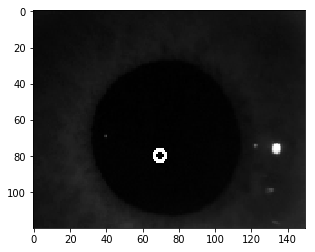

In [335]:
def add_circle(img_mat,center,radius,luminance):
    for rad in np.arange(0,2*np.pi, 0.01):
        for width in [-0.5, 0, 0.5]: # give width to the circle for viewing
            x = int(center[0] + (radius+width) * np.cos(rad))
            y = int(center[1] + (radius+width) * np.sin(rad))
            img_mat[x,y] = luminance
    return

show_circle_img = img.copy()
for r in pupil_radii:
    add_circle(show_circle_img,center,r,255)
show_image(show_circle_img)

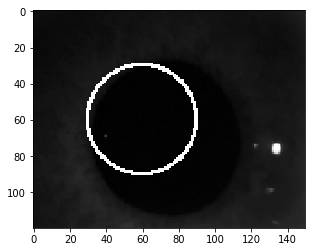

In [336]:
# let's have center and size that are slightly off and fix it
wrong_center = (60, 60) # might have some error
wrong_radius = 30 

show_circle_img = img.copy()
add_circle(show_circle_img,wrong_center,wrong_radius,255)
show_image(show_circle_img)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -23.013006014860963
            Iterations: 16
            Function evaluations: 85
            Gradient evaluations: 16
(59.29195007111004, 61.02921598827132) 27.04685396623588


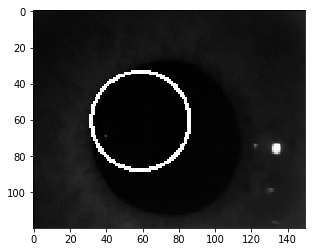

In [339]:
from scipy.optimize import minimize

def optimize_pupil_fit_SLSQP(img, center, radius, step=1.0, max_range=3.0):
    cx = center[0]
    cy = center[1]
    r = radius
    dog_filter = np.zeros(img.shape)
    
    def filter_score2(x):
        score = filter_score(img, dog_filter, center=(x[0],x[1]), radius=x[2])
        return -score
    
    x0 = ([cx,cy,r])
    bounds = ((55, 100), (60, 110), (20, 60))
    res = minimize(filter_score2, x0, method='SLSQP', options={'disp':True}, bounds=bounds)
    return (res.x)

(max_center_x, max_center_y, max_radius) = optimize_pupil_fit_SLSQP(img, wrong_center, wrong_radius)
max_center = (max_center_x, max_center_y)
print(max_center, max_radius)
show_circle_img = img.copy()
add_circle(show_circle_img,max_center,max_radius,255)
show_image(show_circle_img)

##### max_center = (max_center_x, max_center_y)
print(max_center, max_radius)
show_circle_img = img.copy()
add_circle(show_circle_img,max_center,max_radius,255)
show_image(show_circle_img)

In [110]:
""""
def image_sequence_resolve_all(filepath):
    import os

    basedir, filename = os.path.split(filepath)
    filename_noext, ext = os.path.splitext(filename)

    from string import digits
    if isinstance(filepath, bytes):
        digits = digits.encode()
    filename_nodigits = filename_noext.rstrip(digits)

    if len(filename_nodigits) == len(filename_noext):
        # input isn't from a sequence
        return []

    return [
        f.path
        for f in os.scandir(basedir)
        if f.is_file() and
           f.name.startswith(filename_nodigits) and
           f.name.endswith(ext) and
           f.name[len(filename_nodigits):-len(ext) if ext else -1].isdigit()
    ]


# example use
print(image_sequence_resolve_all("C:/Users/Ethan/Downloads/pupil_frames/frame46.jpg"))
show_circle_img = img.copy()
add_circle(show_circle_img,max_center,max_radius,255)
show_image(show_circle_img)
""""


SyntaxError: EOL while scanning string literal (<ipython-input-110-4468f8f6b057>, line 32)

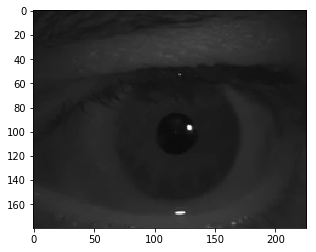